In [2]:
import numpy as np
import scipy as sp
from scipy import signal
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import os
import sys
import pickle
import sys
import copy
from data_preprocess import data_1D_to_2D
from channel_maps import channel_label_map, channel_loc_map
from MvmtOnsetDetect import *

import math


# Load data

In [3]:
db_dir = "C:/Users/Liangyu/Desktop/BME725/Final Project/eeg-deeplearning/neural_network/src"
ME_db_fname = "prelim_ME_db_128.pickle"
ME_Kin_db_fname = "noneeg_ME_db_128.pickle"
fs = 128
ME_db = {}
ME_kin_db = {}


t1 = time.time()
with open(db_dir + "/" + ME_db_fname, "rb") as f:
    ME_db = pickle.load(f)
with open(db_dir + "/" + ME_Kin_db_fname, "rb") as f:
    ME_kin_db = pickle.load(f)
print("Loaded ME database in %f s" % (time.time()-t1))

# normalize by to be between 0 and 1

ME_db_norm = copy.deepcopy(ME_db)
for i in range(1,8):
    for j in range(0,900):
        tmpTrial = copy.deepcopy(ME_db[i][j])
        
        for k in range(0,64):
            tmpChan = tmpTrial[:,k]
            tmpChan = tmpChan[2:len(tmpChan)-2]
            try:
                tmpChanDetr = signal.detrend(tmpChan)
                tmpRepEnd = np.ones(2)*tmpChanDetr[len(tmpChanDetr)-1]
                tmpRepStart = np.ones(2)*tmpChanDetr[0]
                padDat = np.concatenate((tmpRepStart, tmpChanDetr, tmpRepEnd))
                ME_db_norm[i][j][:,k] = padDat
            except:
                ME_db_norm[i][j][:,k] = ME_db_norm[i][j][:,k]
            
    print(" %f s" % (time.time()-t1))

Loaded ME database in 2.664876 s
 23.859143 s
 44.459742 s
 64.937211 s
 85.180335 s
 105.640152 s
 125.928744 s
 147.182288 s


# Perform Movement Onset Detection

In [4]:
onsetAll = np.zeros((8,900))
chElbow = [22,23,24]#[86, 87, 89]
chForeArm = [29]#[93]
chHand = list(range(0, 14))#list(range(64, 79))
plot = False
t1 = time.time()

onsetAll = detectOnset(ME_kin_db, onsetAll, 1, chElbow, 16, 1, 0.01, 17, plot)
onsetAll = detectOnset(ME_kin_db, onsetAll, 2, chElbow, 16, 1, 0.01, 17, plot)
onsetAll = detectOnset(ME_kin_db, onsetAll, 3, chForeArm, 16, 1, 0.01, 17, plot)
onsetAll = detectOnset(ME_kin_db, onsetAll, 4, chForeArm, 16, 1, 0.01, 17, plot)
onsetAll = detectOnsetPCA(ME_kin_db, onsetAll, 5, chHand, 16, 0.1, 0.002, 17, plot)
onsetAll = detectOnsetPCA(ME_kin_db, onsetAll, 6, chHand, 16, 0.1, 0.002, 17, plot)

onsetAll[7,:] = np.mean(onsetAll[1:7,:])
onsetAll = onsetAll.astype(int)

print("Found movement onset in %f s" % (time.time()-t1))

Found movement onset in 12.805591 s


In [5]:
t1 = time.time()
ME_db_New = alignTrials(ME_db_norm, onsetAll, fs)
print("Created new structure in %f s" % (time.time()-t1))

t1 = time.time()
ME_kin_db_New = alignTrials(ME_kin_db, onsetAll, fs)
print("Created new structure in %f s" % (time.time()-t1))

[385, 7, 900, 257, 64]

Created new structure in 2.753634 s


[385, 7, 900, 257, 32]

Created new structure in 1.475102 s


(900, 257, 32)

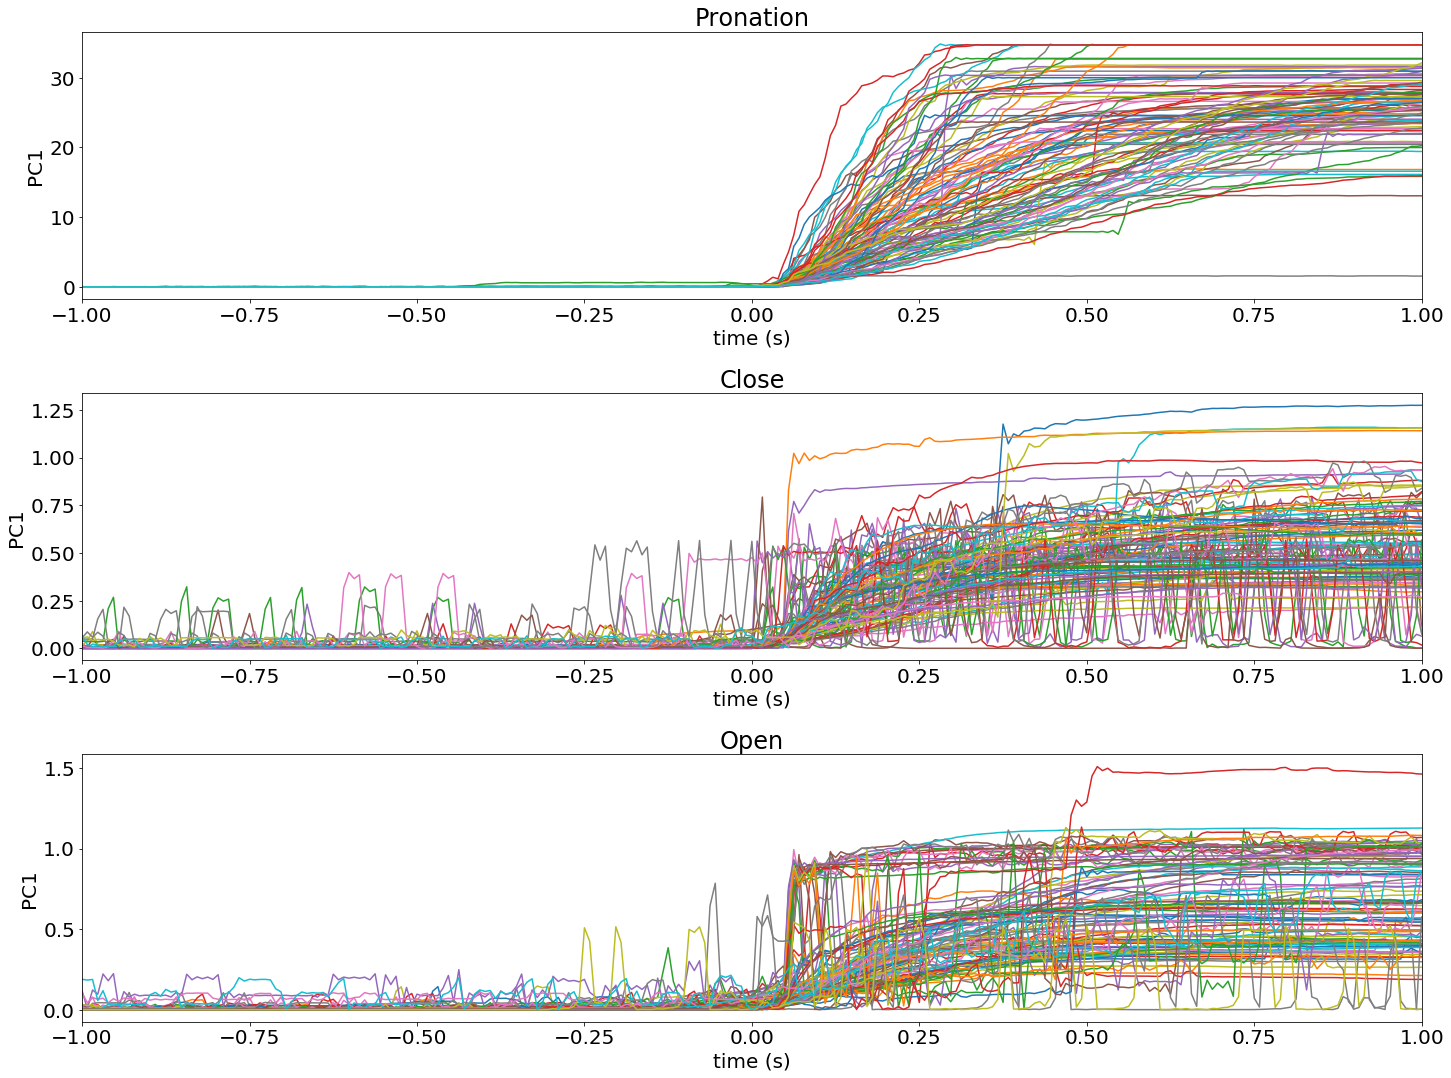

In [88]:
display(ME_kin_db_New[1].shape)
maxVals = np.zeros((6,900))

fs = 128
xRange = (np.arange(257)-(257-1)/2)/fs

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

fig, (axs) = plt.subplots(3, 1, figsize = (20,15))
#plt.tight_layout()
for i in range(0,100):
    for j in range(1,3):
        tmp = abs(ME_kin_db_New[j][i][:,24])+abs(ME_kin_db_New[j][i][:,23])+abs(ME_kin_db_New[j][i][:,22])
        maxVals[j-1,i] = np.max(tmp)
        #if j==1:
        #    axs[0].plot(tmp)
        #if j==2:
        #    axs[1].plot(tmp)
        
    for j in range(3,5):
        tmp2 = abs(ME_kin_db_New[j][i][:,29]-np.mean(ME_kin_db_New[j][i][0:16,29]))
        maxVals[j-1,i] = np.max(tmp2)
        #if j==2:
        #    axs[2].plot(tmp2)
        if j==3:
            axs[0].plot(xRange,tmp2)
        
    for j in range(5,7):
        X = ME_kin_db_New[j][i][:,list(range(0, 14))]
        pca = PCA(n_components=np.shape(X)[1])
        PC = pca.fit_transform(X)
        tmp3 = abs(PC[:,0]-np.mean(PC[0:16,0]))
        maxVals[j-1,i] = np.max(tmp3)
        if j==5:
            axs[1].plot(xRange,tmp3)
        if j==6:
            axs[2].plot(xRange,tmp3)
            
claslabels = ['Pronation','Close','Open']            
for i in range(0,3):
    axs[i].set_xlim([xRange.min(),xRange.max()])
    axs[i].set_title(claslabels[i])
    axs[i].set_xlabel('time (s)')
    axs[i].set_ylabel('PC1')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

fig.savefig("MovementAlignOnset.pdf", bbox_inches='tight')

In [77]:
nPt

NameError: name 'nPt' is not defined

(900, 257, 32)

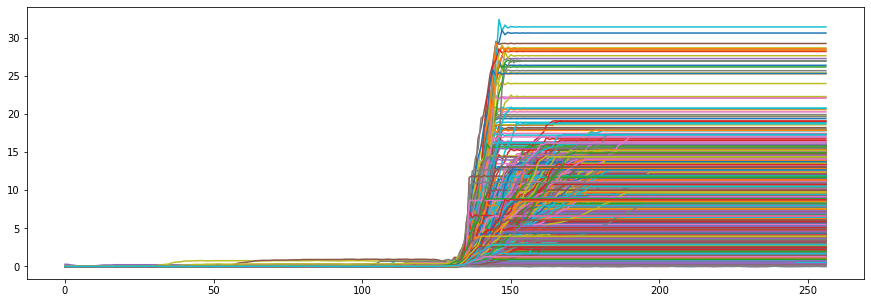

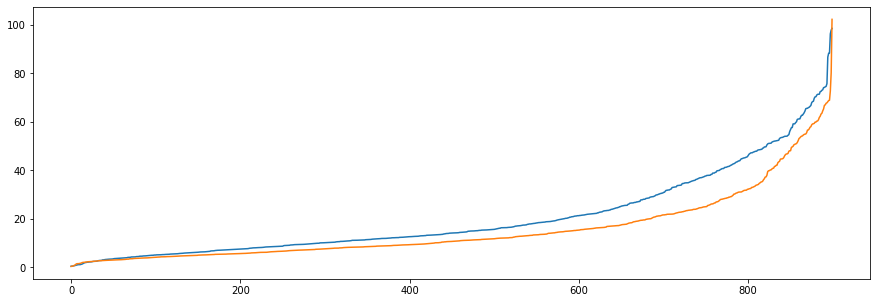

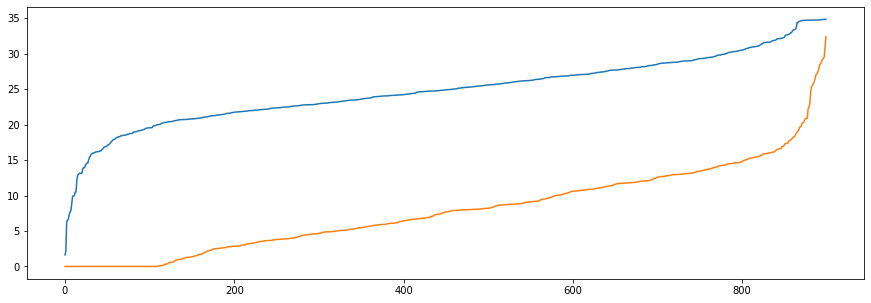

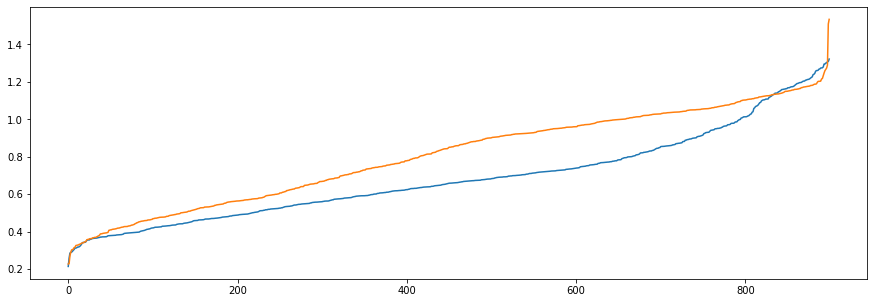

In [55]:
display(ME_kin_db_New[1].shape)
maxVals = np.zeros((6,900))
plt.figure(figsize = (15,5))
for i in range(0,900):
    for j in range(1,3):
        tmp = abs(ME_kin_db_New[j][i][:,24])+abs(ME_kin_db_New[j][i][:,23])+abs(ME_kin_db_New[j][i][:,22])
        maxVals[j-1,i] = np.max(tmp)
    for j in range(3,5):
        tmp2 = abs(ME_kin_db_New[j][i][:,29]-np.mean(ME_kin_db_New[j][i][0:16,29]))
        maxVals[j-1,i] = np.max(tmp2)
    for j in range(5,7):
        X = ME_kin_db_New[j][i][:,list(range(0, 14))]
        pca = PCA(n_components=np.shape(X)[1])
        PC = pca.fit_transform(X)
        tmp3 = abs(PC[:,0]-np.mean(PC[0:16,0]))
        maxVals[j-1,i] = np.max(tmp3)
    plt.plot(tmp2)
        
plt.figure(figsize = (15,5))
plt.plot(np.sort(maxVals[0,:]))
plt.plot(np.sort(maxVals[1,:]))

plt.figure(figsize = (15,5))
plt.plot(np.sort(maxVals[2,:]))
plt.plot(np.sort(maxVals[3,:]))

plt.figure(figsize = (15,5))
plt.plot(np.sort(maxVals[4,:]))
plt.plot(np.sort(maxVals[5,:]))

In [43]:
j

2

# Convert from 1D to 2D

In [9]:
CLM = channel_loc_map()
# populate the mesh with the electrodes
mesh = [ [ "" for y in range(0,9) ] for x in range(0,9) ] 
for chan in range(0,np.shape(CLM)[0]):
    mesh[CLM[chan][0]][CLM[chan][1]] = channel_label_map[chan+1]

# print the 2D mesh of channels
for x in range(0,9): 
    print(mesh[x])

t1 = time.time()
ME_db_2Dmesh = data_1D_to_2D(ME_db_New, 9, 9, CLM)
print("Converting 1D to 2D mesh takes %f s" % (time.time()-t1))

['', '', '', '', 'F4', 'FFC6h', 'FC6', 'FTT8h', '']
['', '', '', 'F2', 'FFC4h', 'FC4', 'FCC6h', 'C6', 'TTP8h']
['', '', 'Fz', 'FFC2h', 'FC2', 'FCC4h', 'C4', 'CCP6h', 'CP6']
['', 'F1', 'FFC1h', 'FCz', 'FCC2h', 'C2', 'CCP4h', 'CP4', 'CPP6h']
['F3', 'FFC3h', 'FC1', 'FCC1h', 'Cz', 'CCP2h', 'CP2', 'CPP4h', 'P4']
['FFC5h', 'FC3', 'FCC3h', 'C1', 'CCP1h', 'CPz', 'CPP2h', 'P2', '']
['FC5', 'FCC5h', 'C3', 'CCP3h', 'CP1', 'CPP1h', 'Pz', 'PPO2h', '']
['FTT7h', 'C5', 'CCP5h', 'CP3', 'CPP3h', 'P1', 'PPO1h', '', '']
['', 'TTP7h', 'CP5', 'CPP5h', 'P3', '', '', '', '']
Converting 1D to 2D mesh takes 162.874415 s


In [10]:
t1 = time.time()
f = open("mesh_ME_db_128.pickle", "wb")
i_str = pickle.dumps(ME_db_2Dmesh)
f_size = sys.getsizeof(i_str)/1048576
f.write(i_str)
f.close()
print("Finished writing %.2f MB of data to mesh_ME_db_128.pickle in %f s" % (f_size, time.time()-t1))

Finished writing 1000.57 MB of data to mesh_ME_db_128.pickle in 6.285372 s


# Reject Abnormal Trials

In [13]:
rej_ME_db_fname = "reject_ME_db.pickle"
rej_ME_db = {}

t1 = time.time()
with open(db_dir + "/" + rej_ME_db_fname, "rb") as f:
    rej_ME_db = pickle.load(f)

In [68]:
nTrials = ME_db_2Dmesh[1].shape[0]
nPts = ME_db_2Dmesh[1].shape[1]
nGrid = 9
t1 = time.time()

nGoodTrials = np.zeros(8, dtype=int)
ME_db_2Dmesh_No_Art = {}
for clas in range(1,8):
    ME_db_2Dmesh_No_Art[clas] = np.zeros((nTrials,nPts,nGrid,nGrid))

for clas in range(1,8):
    tmp = ME_db_2Dmesh[clas]
    
    for trial in range(899, -1, -1):
        rej_trial = rej_ME_db[clas][trial]
        if rej_trial:
            tmp = np.delete(tmp, trial, axis=0)
    
    nGoodTrials[clas] = tmp.shape[0]
    for trial in range(0,tmp.shape[0]):
        ME_db_2Dmesh_No_Art[clas][trial] = tmp[trial]
        
print("Removing artifacts %f s" % (time.time()-t1))

Removing artifacts 100.403770 s


In [69]:
minGoodTrial = np.min(nGoodTrials[1:])
display(minGoodTrial)

ME_db_2Dmesh_No_Art = copy.deepcopy(ME_db_2Dmesh_No_Art)
for clas in range(1,8):
    tmp = ME_db_2Dmesh[clas]
    ME_db_2Dmesh_No_Art[clas] = ME_db_2Dmesh_No_Art[clas][0:minGoodTrial,:,:]


749

In [84]:
del ME_db
t1 = time.time()
f = open("mesh_NoArt_ME_db_128.pickle", "wb")
i_str = pickle.dumps(ME_db_2D_No_Art)
f_size = sys.getsizeof(i_str)/1048576
f.write(i_str)
f.close()
print("Finished writing %.2f MB of data to mesh_NoArt_ME_db_128.pickle in %f s" % (f_size, time.time()-t1))

Finished writing 832.70 MB of data to mesh_NoArt_ME_db_128.pickle in 5.441831 s


In [58]:
rej_ME_db

NameError: name 'rej_ME_db' is not defined

In [62]:
rej_ME_db_fname = "reject_ME_db.pickle"
rej_ME_db = {}
t1 = time.time()
with open(db_dir + "/" + rej_ME_db_fname, "rb") as f:
    rej_ME_db = pickle.load(f)


nTrials = ME_db_New[1].shape[0]
nPts = ME_db_New[1].shape[1]
nGrid = 9
t1 = time.time()

nGoodTrials = np.zeros(8, dtype=int)
ME_db_New_No_Art = {}
for clas in range(1,8):
    ME_db_New_No_Art[clas] = np.zeros((nTrials,nPts,64))

for clas in range(1,8):
    tmp = ME_db_New[clas]
    
    for trial in range(899, -1, -1):
        rej_trial = rej_ME_db[clas][trial]
        if rej_trial:
            tmp = np.delete(tmp, trial, axis=0)
    
    nGoodTrials[clas] = tmp.shape[0]
    for trial in range(0,tmp.shape[0]):
        ME_db_New_No_Art[clas][trial] = tmp[trial]
        
print("Removing artifacts %f s" % (time.time()-t1))

minGoodTrial = np.min(nGoodTrials[1:])
display(minGoodTrial)

ME_db_New_No_Art = copy.deepcopy(ME_db_New_No_Art)
for clas in range(1,8):
    tmp = ME_db_New[clas]
    ME_db_New_No_Art[clas] = ME_db_New_No_Art[clas][0:minGoodTrial,:,:]


Removing artifacts 79.128612 s


749

In [65]:
len(ME_db_New_No_Art)
ME_db_New_No_Art[1].shape

(749, 257, 64)

In [67]:
del ME_db
t1 = time.time()
f = open("NoArt_ME_db_128.pickle", "wb")
i_str = pickle.dumps(ME_db_New_No_Art)
f_size = sys.getsizeof(i_str)/1048576
f.write(i_str)
f.close()
print("Finished writing %.2f MB of data to NoArt_ME_db_128.pickle in %f s" % (f_size, time.time()-t1))

Finished writing 657.94 MB of data to NoArt_ME_db_128.pickle in 2.910221 s


# plot the raw mrcp

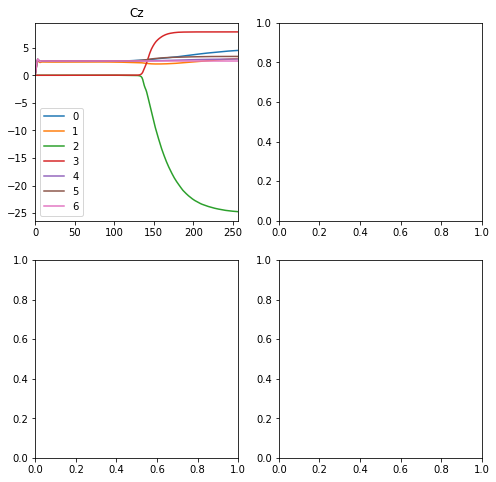

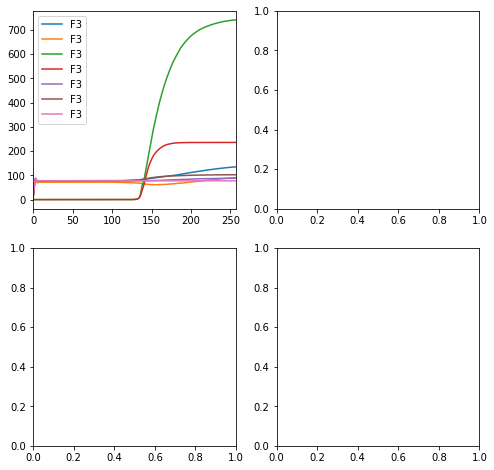

In [6]:
plotMRCP(ME_kin_db_New, [29])
plotMRCP(ME_db_norm, [14, 27, 30, 31])
plotMRCP(ME_db_New, [14, 27, 30, 31])